In [ ]:
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

In [ ]:
######################################################################
# COMP-579 HW1
# 2023 Shankhin Brahmavar (shankhin.brahmavar@mail.mcgill.ca)
######################################################################

#create a bandit class that has inputs:
#initial reward guesses for actions
#probability of each action (pi)
#the action_prob defines the probability of selecting each action (useful when plotting samples of 1 particular action)

class Bandit:

    #intial_action_value: initial estimates of actions
    #success_prob: probability of success of each action
    #epsilon: set to a number between 0 and 1 to use the e-greedy action selection method
    #UCB_constant: set to a constant go use UCB action selecting method 
    #thompson: set to true to choose the thompson action selecting method
    #increment: used to select sample averaging method for estimating the rewards
    #alpha: used to set the step size in the weighted avg method

    #time_step: discrete time steps 
    #k_arms: the number of bandits
    #estimate_reward: the estimated reward of each action
    #actions_indices: the indices of each action [0, 1, ..., k]

    def __init__(self, initial_action_values = 0., success_prob = [0.5, 0.5-0.1, 0.5-2*0.1], epsilon = None, UCB_constant = None, thompson = None, increment = None, alpha = None):
        
        self.initial_action_values = initial_action_values
        self.success_prob = success_prob
        self.epsilon = epsilon
        self.increment = increment
        self.alpha = alpha
        self.UCB_constant = UCB_constant
        self.thompson = thompson

        self.time_step = 0
        self.k_arms = 3
        self.estimate_reward = np.zeros(self.k_arms) + self.initial_action_values
        self.action_indices = np.arange(self.k_arms)
        self.q_star = success_prob 
        self.N_t = np.zeros(self.k_arms)

    # used to reset the bandit from one run to the other
    def reset(self):
        self.time_step = 0
        self.estimate_reward = np.zeros(self.k_arms) + self.initial_action_values

    # selects an action based on the different methods. Returns the index of the selected action
    def action_select(self, successes = None, failures = None):
        self.successes = successes
        self.failures = failures
        if self.epsilon is not None:
            if np.random.rand()<self.epsilon:
                self.action_index = np.random.choice(self.action_indices)
            else:
                self.action_index = np.random.choice(np.flatnonzero(self.estimate_reward == np.max(self.estimate_reward)))

        if self.UCB_constant is not None:
            self.action_index = np.argmax(self.estimate_reward + self.UCB_constant*np.sqrt(np.log(self.time_step + 0.1)/(self.N_t + 0.1))) #to avoid dividing by zero

        if self.thompson is not None:
            betas = [np.random.beta(1+ int(self.successes[index]), 1+ int(self.failures[index])) for index in range(self.k_arms)]
            self.action_index = np.argmax(betas)

        self.N_t[self.action_index] += 1
        return self.action_index


    # sample function that takes the action index as the input and outputs the value of the action
    def sample(self, action_index = None):
        if action_index is not None:
            self.action_index = action_index

        self.time_step += 1
        self.action_sample = np.random.binomial(1, self.success_prob[self.action_index], 1)
        return self.action_sample


    # estimate calculation using constant stepsize alpha
    def update(self):
        self.estimate_reward[self.action_index] = self.estimate_reward[self.action_index] + (self.action_sample - self.estimate_reward[self.action_index])*self.alpha #updates the reward estimate for the selected action
        return self.estimate_reward


    # this function updates the reward estimate via the incremental computation of the mean
    def updateavg(self):
        self.estimate_reward[self.action_index] = self.estimate_reward[self.action_index] + (self.action_sample - self.estimate_reward[self.action_index])/self.time_step #updates the reward estimate for the selected action
        return self.estimate_reward

    # this function selects which update method to use
    def update_selector(self):
        if self.increment is not None:
            self.updateavg()
        elif self.alpha is not None:
            self.update()
        return self.estimate_reward

    # this functions returns the instantanous regret
    def regret(self):
        self.intantanous_regret = max(self.q_star) - self.q_star[self.action_index]
        return self.intantanous_regret

    #this functions changes the success probabilities of the actions to simulate a non-stationary problem
    def non_stationary(self, d):
        self.d = d
        self.success_prob = [0.5, 0.5 + self.d, 0.5 + 2*self.d]



QUESTION 1


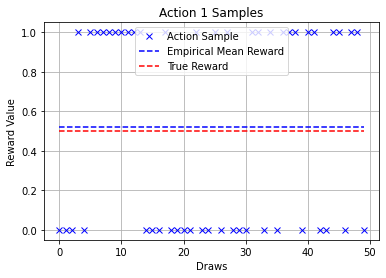

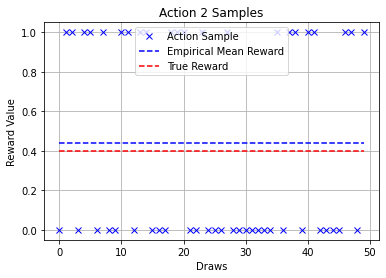

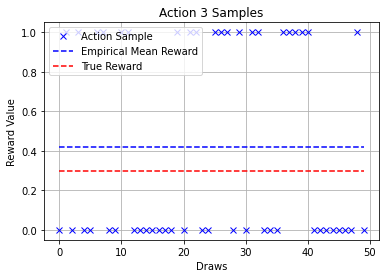

In [ ]:
# Q1
# generate a set of samples for each action
print("QUESTION 1")
bandit = Bandit(success_prob = [0.5, 0.5-0.1, 0.5-2*0.1])
draws = 50
k_arms = 3
action_rewards = np.zeros((k_arms, draws))
for action in range(k_arms):
    for draw in range(draws):
        action_rewards[action, draw] = bandit.sample(action_index=action)
    mean_rewards = action_rewards.mean(axis=1)

# plotting
true_rewards = [0.5, 0.4, 0.3]
for i in range(k_arms):
    plt.figure()
    plt.plot(action_rewards[i,:], 'bx', mean_rewards[i]*np.ones(draws), 'b--', true_rewards[i]*np.ones(draws) , 'r--')
    plt.xlabel("Draws")
    plt.ylabel("Reward Value")
    plt.grid()
    plt.legend(["Action Sample", "Empirical Mean Reward", "True Reward"])
    plt.title(f"Action {i+1} Samples")
    plt.savefig(f'figure_1_{i+1}.png')


QUESTION 2


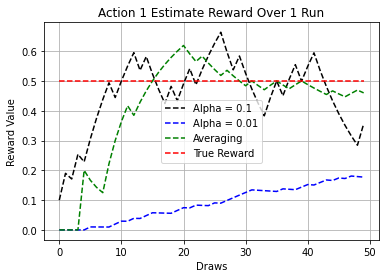

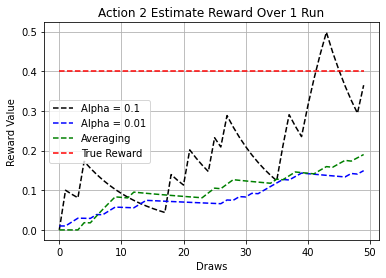

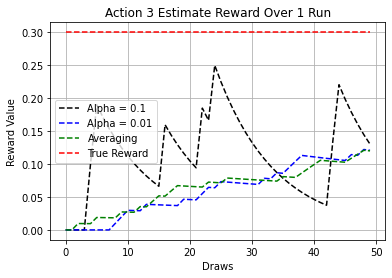

In [ ]:
# Q2
# generate a set of samples for each action
print("QUESTION 2")
bandits = [Bandit(alpha=0.1), Bandit(alpha=0.01), Bandit(increment=True)]
draws = 50
k_arms = 3
action_rewards = np.zeros((len(bandits), k_arms, draws))
estimate_rewards = np.zeros((len(bandits), k_arms, draws))
for i, bandit in enumerate(bandits):
    for action in range(k_arms):
        for draw in range(draws):
            action_rewards[i, action, draw] = bandit.sample(action_index=action)
            estimate_rewards[i, action, draw]  = bandit.update_selector()[action]
        mean_rewards = action_rewards.mean(axis=1)

# Plotting
colors =['k--', 'b--', 'g--']
for i in range(k_arms):
    plt.figure()
    for j in range(len(bandits)):
        plt.plot(estimate_rewards[j, i, :], colors[j])
    plt.plot(true_rewards[i]*np.ones(draws) , 'r--')
    plt.xlabel("Draws")
    plt.ylabel("Reward Value")
    plt.grid()
    #plt.ylim([0,1])
    plt.legend(["Alpha = 0.1", "Alpha = 0.01", "Averaging", "True Reward"])
    plt.title(f"Action {i+1} Estimate Reward Over 1 Run")
    plt.savefig(f'figure_2_{i+1}.png')

QUESTION 3


100%|██████████| 100/100 [00:00<00:00, 116.16it/s]


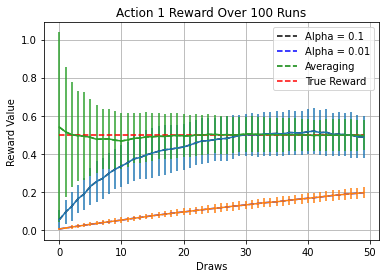

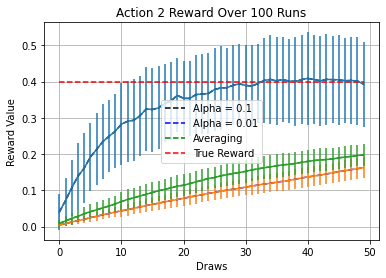

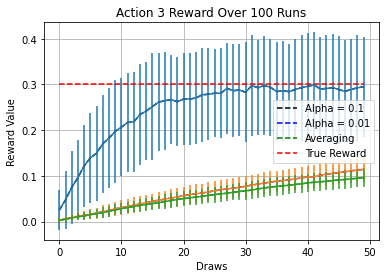

In [ ]:
# Q3
# generate a set of samples for each action
print("QUESTION 3")
bandits = [Bandit(alpha=0.1), Bandit(alpha=0.01), Bandit(increment=True)]
draws = 50
runs = 100
k_arms = 3
action_rewards = np.zeros((len(bandits), runs, k_arms, draws))
estimate_rewards = np.zeros((len(bandits), runs, k_arms, draws))
errors = np.zeros((len(bandits), runs, k_arms, draws))


for i, bandit in enumerate(bandits):
    for run in trange(runs):
        bandit.reset()
        for action in range(k_arms):
            for draw in range(draws):
                action_rewards[i, run, action, draw] = bandit.sample(action_index=action)
                estimate_rewards[i, run, action, draw]  = bandit.update_selector()[action]
                #errors[i, run, action, draw] = action_rewards[i, run, action, draw]  - estimate_rewards[i, run, action, draw] 
#assert False
rewards_run_avg = action_rewards.mean(axis=1)
estimate_run_avg = estimate_rewards.mean(axis=1)
estimate_run_errors = estimate_rewards.std(axis=1)
x = np.arange(0, draws, 1)
colors =['k--', 'b--', 'g--']
for i in range(k_arms):
    plt.figure()
    for j in range(len(bandits)):
        plt.plot(estimate_run_avg[j, i, :], colors[j])
        plt.errorbar(x, estimate_run_avg[j, i, :], yerr = estimate_run_errors[j,i,:])
    plt.plot(true_rewards[i]*np.ones(draws) , 'r--')
    plt.xlabel("Draws")
    plt.ylabel("Reward Value")
    plt.grid()
    #plt.ylim([0,1])
    plt.legend(["Alpha = 0.1", "Alpha = 0.01", "Averaging", "True Reward"])
    plt.title(f"Action {i+1} Reward Over 100 Runs")
    plt.savefig(f'figure_3_{i+1}.png')


# for i in range(k_arms):
#     plt.figure()
#     for j in range(len(bandits)):
#         plt.plot(errors_run_avg[j, i, :], colors[j])
#     plt.xlabel("Draws")
#     plt.ylabel("Error")
#     plt.grid()
#     #plt.ylim([0,1])
#     plt.legend(["Alpha = 0.1", "Alpha = 0.01", "Averaging"])
#     plt.title(f"Action {i+1} Error Over 100 Runs")
#     plt.savefig(f'figure_3_{i+4}.png')

QUESTION 4


100%|██████████| 100/100 [00:05<00:00, 17.98it/s]


(5, 100, 1000)
(5, 100, 1000)
(5, 100, 1000)


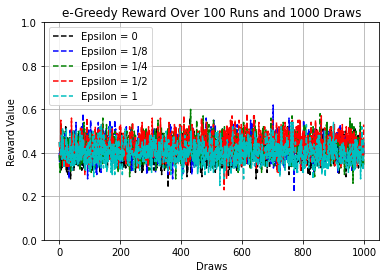

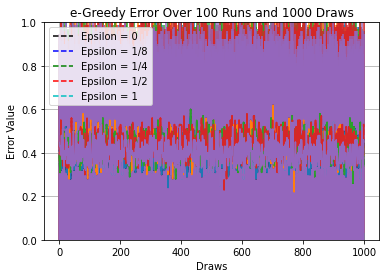

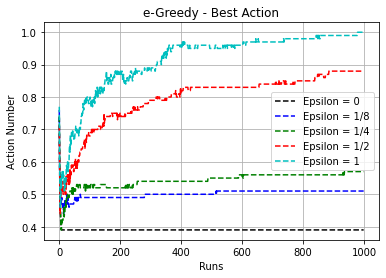

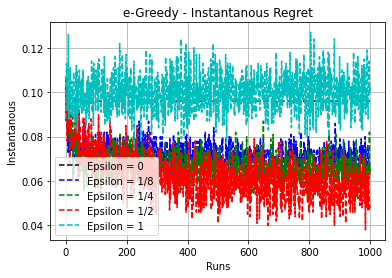

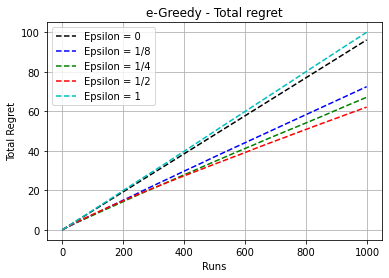

In [ ]:
# Q4
# e-Greedy with different epsilons and averaging
print("QUESTION 4")
epsilons = [0, 1/8, 1/4, 1/2, 1]
true_rewards = [0.5, 0.4, 0.3]
bandits = [Bandit(increment=True, epsilon=eps) for eps in epsilons]
draws = 1000
runs = 100
k_arms = 3
action_rewards = np.zeros((len(bandits), runs, draws))
estimate_rewards = np.zeros((len(bandits), runs, draws))
action_indices = np.zeros((len(bandits), runs, draws))
errors = np.zeros((len(bandits), runs, draws))
is_action1_best = np.zeros((len(bandits), runs, draws))
intanstanous_regret = np.zeros((len(bandits), runs, draws))



for i, bandit in enumerate(bandits):
    for run in trange(runs):
        bandit.reset()
        for draw in range(draws):
            action_indices[i, run, draw] = bandit.action_select()
            action_rewards[i, run, draw] = bandit.sample()
            estimate_rewards[i, run, draw] = bandit.update_selector()[int(action_indices[i, run, draw])]
            #errors[i, run, draw] = action_rewards[i, run, draw] - estimate_rewards[i, run, draw]
            intanstanous_regret[i, run, draw] = bandit.regret()
            is_action1_best[i, run, draw] = 1 if np.argmax(bandit.update_selector()) + 1 == 1 else 0

print(estimate_rewards.shape)
print(is_action1_best.shape)
is_action1_best_frac = np.cumsum(is_action1_best, axis=1)/runs
print(is_action1_best_frac.shape)
rewards_run_avg = action_rewards.mean(axis=1)
rewards_run_errors = action_rewards.std(axis=1)
cum_rewards_run_avg = np.cumsum(rewards_run_avg, axis=1)
#errors_run_avg = errors.mean(axis=1)
intanstanous_regret_run_avg = intanstanous_regret.mean(axis=1)
total_regret_run_avg = np.cumsum(intanstanous_regret_run_avg, axis=1)


# Plotting 
colors =['k--', 'b--', 'g--', 'r--', 'c--']
plt.figure()
for i in range(len(bandits)):
    plt.plot(rewards_run_avg[i, :], colors[i]) 
plt.xlabel("Draws")
plt.ylabel("Reward Value")
plt.ylim((0,1))
plt.grid()
plt.legend(["Epsilon = 0", "Epsilon = 1/8", "Epsilon = 1/4", "Epsilon = 1/2", "Epsilon = 1"])
plt.title("e-Greedy Reward Over 100 Runs and 1000 Draws")
plt.savefig('figure_4_1.png')

x = np.arange(0, draws, 1)
# Plotting
plt.figure()
for i in range(len(bandits)):
    plt.plot(rewards_run_avg[i, :], colors[i])
    plt.errorbar(x, rewards_run_avg[i,:], yerr = rewards_run_errors[i, :])
plt.xlabel("Draws")
plt.ylabel("Error Value")
plt.ylim((0,1))
plt.grid()
plt.legend(["Epsilon = 0", "Epsilon = 1/8", "Epsilon = 1/4", "Epsilon = 1/2", "Epsilon = 1"])
plt.title("e-Greedy Error Over 100 Runs and 1000 Draws")
plt.savefig('figure_4_2.png')


# Plotting
colors =['k--', 'b--', 'g--', 'r--', 'c--']
plt.figure()
for i in range(len(bandits)):
    plt.plot(is_action1_best_frac[i, -1,  :], colors[i])
plt.xlabel("Runs")
plt.ylabel("Action Number")
#plt.ylim((0,4))
plt.grid()
plt.legend(["Epsilon = 0", "Epsilon = 1/8", "Epsilon = 1/4", "Epsilon = 1/2", "Epsilon = 1"])
plt.title("e-Greedy - Best Action")
plt.savefig('figure_4_3.png')

# plotting
colors =['k--', 'b--', 'g--', 'r--', 'c--']
plt.figure()
for i in range(len(bandits)):
    plt.plot(intanstanous_regret_run_avg[i, :], colors[i])
plt.xlabel("Runs")
plt.ylabel("Instantanous")
plt.grid()
plt.legend(["Epsilon = 0", "Epsilon = 1/8", "Epsilon = 1/4", "Epsilon = 1/2", "Epsilon = 1"])
plt.title("e-Greedy - Instantanous Regret")
plt.savefig('figure_4_4.png')

# plotting
colors =['k--', 'b--', 'g--', 'r--', 'c--']
plt.figure()
for i in range(len(bandits)):
    plt.plot(total_regret_run_avg[i, :], colors[i])
plt.xlabel("Runs")
plt.ylabel("Total Regret")
plt.grid()
plt.legend(["Epsilon = 0", "Epsilon = 1/8", "Epsilon = 1/4", "Epsilon = 1/2", "Epsilon = 1"])
plt.title("e-Greedy - Total regret")
plt.savefig('figure_4_5.png')



QUESTION 5


100%|██████████| 100/100 [00:06<00:00, 14.77it/s]


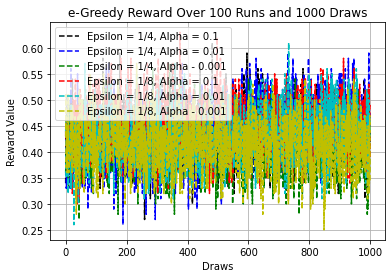

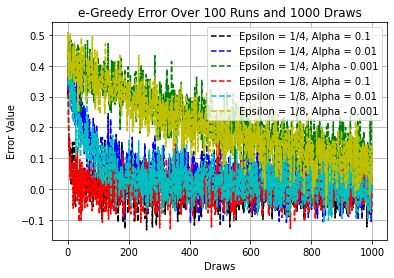

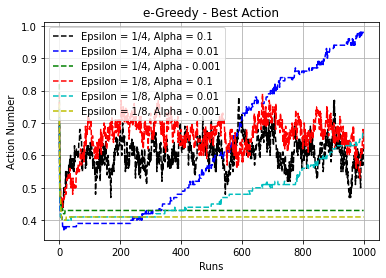

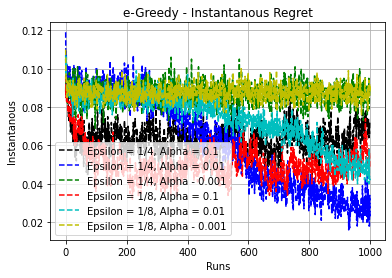

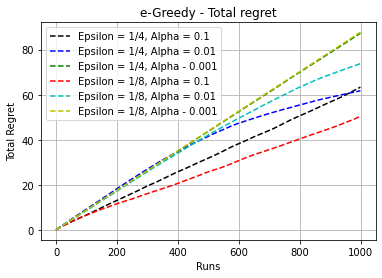

In [ ]:
# Q5
# e-Greedy with epsilons = 1/4, 1/8 and alpha = 0.1, 0.01, 0.001
print("QUESTION 5")
alphas = [0.1, 0.01, 0.001]
true_rewards = [0.5, 0.4, 0.3]
bandits1 = [Bandit(alpha = alp, epsilon= 1/4) for alp in alphas]
bandits2 = [Bandit(alpha = alp, epsilon= 1/8) for alp in alphas]
bandits = np.concatenate((bandits1, bandits2), axis=0)

draws = 1000
runs = 100
k_arms = 3
action_rewards = np.zeros((len(bandits), runs, draws))
estimate_rewards = np.zeros((len(bandits), runs, draws))
action_indices = np.zeros((len(bandits), runs, draws))
errors = np.zeros((len(bandits), runs, draws))
is_action1_best = np.zeros((len(bandits), runs, draws))
intanstanous_regret = np.zeros((len(bandits), runs, draws))



for i, bandit in enumerate(bandits):
    for run in trange(runs):
        bandit.reset()
        for draw in range(draws):
            action_indices[i, run, draw] = bandit.action_select()
            action_rewards[i, run, draw] = bandit.sample()
            estimate_rewards[i, run, draw] = bandit.update_selector()[int(action_indices[i, run, draw])]
            errors[i, run, draw] = action_rewards[i, run, draw] - estimate_rewards[i, run, draw]
            intanstanous_regret[i, run, draw] = bandit.regret()
            is_action1_best[i, run, draw] = 1 if np.argmax(bandit.update_selector()) + 1 == 1 else 0

is_action1_best_frac = np.cumsum(is_action1_best, axis=1)/runs
rewards_run_avg = action_rewards.mean(axis=1)
errors_run_avg = errors.mean(axis=1)
intanstanous_regret_run_avg = intanstanous_regret.mean(axis=1)
total_regret_run_avg = np.cumsum(intanstanous_regret_run_avg, axis=1)

# Plotting 
colors =['k--', 'b--', 'g--', 'r--', 'c--', 'y--']
plt.figure()
for i in range(len(bandits)):
    plt.plot(rewards_run_avg[i, :], colors[i])
plt.xlabel("Draws")
plt.ylabel("Reward Value")
#plt.ylim((0,1))
plt.grid()
plt.legend(["Epsilon = 1/4, Alpha = 0.1", "Epsilon = 1/4, Alpha = 0.01", "Epsilon = 1/4, Alpha - 0.001", "Epsilon = 1/8, Alpha = 0.1", "Epsilon = 1/8, Alpha = 0.01", "Epsilon = 1/8, Alpha - 0.001"])
plt.title("e-Greedy Reward Over 100 Runs and 1000 Draws")
plt.savefig('figure_5_1.png')


# Plotting
plt.figure()
for i in range(len(bandits)):
    plt.plot(errors_run_avg[i, :], colors[i])
plt.xlabel("Draws")
plt.ylabel("Error Value")
#plt.ylim((0,1))
plt.grid()
plt.legend(["Epsilon = 1/4, Alpha = 0.1", "Epsilon = 1/4, Alpha = 0.01", "Epsilon = 1/4, Alpha - 0.001", "Epsilon = 1/8, Alpha = 0.1", "Epsilon = 1/8, Alpha = 0.01", "Epsilon = 1/8, Alpha - 0.001"])
plt.title("e-Greedy Error Over 100 Runs and 1000 Draws")
plt.savefig('figure_5_2.png')


# Plotting
colors =['k--', 'b--', 'g--', 'r--', 'c--', 'y--']
plt.figure()
for i in range(len(bandits)):
    plt.plot(is_action1_best_frac[i, -1, :], colors[i])
plt.xlabel("Runs")
plt.ylabel("Action Number")
#plt.ylim((0,4))
plt.grid()
plt.legend(["Epsilon = 1/4, Alpha = 0.1", "Epsilon = 1/4, Alpha = 0.01", "Epsilon = 1/4, Alpha - 0.001", "Epsilon = 1/8, Alpha = 0.1", "Epsilon = 1/8, Alpha = 0.01", "Epsilon = 1/8, Alpha - 0.001"])
plt.title("e-Greedy - Best Action")
plt.savefig('figure_5_3.png')

# plotting
colors =['k--', 'b--', 'g--', 'r--', 'c--', 'y--']
plt.figure()
for i in range(len(bandits)):
    plt.plot(intanstanous_regret_run_avg[i, :], colors[i])
plt.xlabel("Runs")
plt.ylabel("Instantanous")
plt.grid()
plt.legend(["Epsilon = 1/4, Alpha = 0.1", "Epsilon = 1/4, Alpha = 0.01", "Epsilon = 1/4, Alpha - 0.001", "Epsilon = 1/8, Alpha = 0.1", "Epsilon = 1/8, Alpha = 0.01", "Epsilon = 1/8, Alpha - 0.001"])
plt.title("e-Greedy - Instantanous Regret")
plt.savefig('figure_5_4.png')

# plotting
colors =['k--', 'b--', 'g--', 'r--', 'c--', 'y--']
plt.figure()
for i in range(len(bandits)):
    plt.plot(total_regret_run_avg[i, :], colors[i])
plt.xlabel("Runs")
plt.ylabel("Total Regret")
plt.grid()
plt.legend(["Epsilon = 1/4, Alpha = 0.1", "Epsilon = 1/4, Alpha = 0.01", "Epsilon = 1/4, Alpha - 0.001", "Epsilon = 1/8, Alpha = 0.1", "Epsilon = 1/8, Alpha = 0.01", "Epsilon = 1/8, Alpha - 0.001"])
plt.title("e-Greedy - Total regret")
plt.savefig('figure_5_5.png')



QUESTION 6


  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-2-ec2877e42a84>:60: RuntimeWarning: invalid value encountered in sqrt
  self.action_index = np.argmax(self.estimate_reward + self.UCB_constant*np.sqrt(np.log(self.time_step + 0.1)/(self.N_t + 0.1))) #to avoid dividing by zero
100%|██████████| 100/100 [00:04<00:00, 24.67it/s]


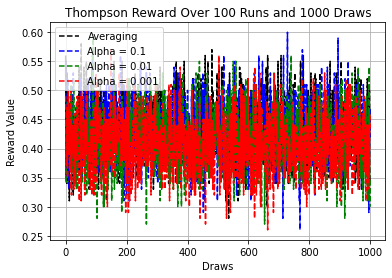

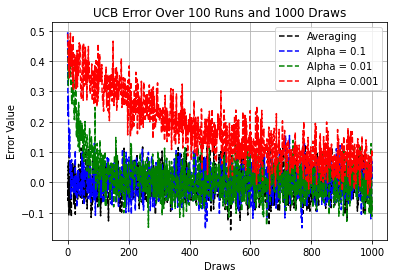

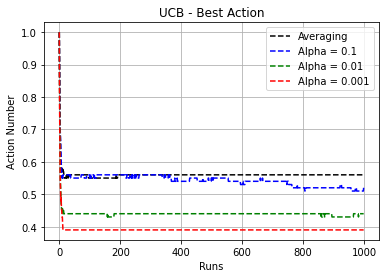

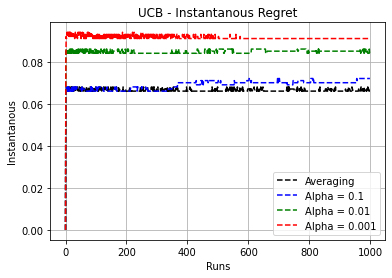

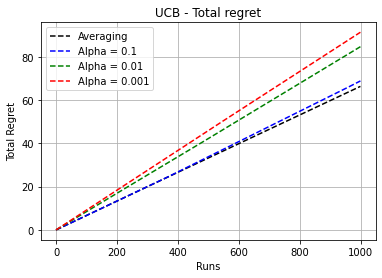

In [ ]:
# Q6
# UCB with averaging, alpha = 0.1, 0.01, 0.001
print("QUESTION 6")
true_rewards = [0.5, 0.4, 0.3]
alphas = [0.1, 0.01, 0.001]
bandits = [Bandit(alpha=alp, UCB_constant=2) for alp in alphas]
bandits.insert(0, Bandit(increment=True, UCB_constant=2))
draws = 1000
runs = 100
k_arms = 3
action_rewards = np.zeros((len(bandits), runs, draws))
estimate_rewards = np.zeros((len(bandits), runs, draws))
action_indices = np.zeros((len(bandits), runs, draws))
errors = np.zeros((len(bandits), runs, draws))
is_action1_best = np.zeros((len(bandits), runs, draws))
intanstanous_regret = np.zeros((len(bandits), runs, draws))


for i, bandit in enumerate(bandits):
    for run in trange(runs):
        bandit.reset()
        for draw in range(draws):
            action_indices[i, run, draw] = bandit.action_select()
            action_rewards[i, run, draw] = bandit.sample()
            estimate_rewards[i, run, draw] = bandit.update_selector()[int(action_indices[i, run, draw])]
            errors[i, run, draw] = action_rewards[i, run, draw] - estimate_rewards[i, run, draw]
            intanstanous_regret[i, run, draw] = bandit.regret()
            is_action1_best[i, run, draw] = 1 if np.argmax(bandit.update_selector()) + 1 == 1 else 0


is_action1_best_frac = np.cumsum(is_action1_best, axis=1)/runs
rewards_run_avg = action_rewards.mean(axis=1)
errors_run_avg = errors.mean(axis=1)
intanstanous_regret_run_avg = intanstanous_regret.mean(axis=1)
total_regret_run_avg = np.cumsum(intanstanous_regret_run_avg, axis=1)

# Plotting 
colors =['k--', 'b--', 'g--', 'r--', 'c--']
plt.figure()
for i in range(len(bandits)):
    plt.plot(rewards_run_avg[i, :], colors[i])
plt.xlabel("Draws")
plt.ylabel("Reward Value")
#plt.ylim((0,1))
plt.grid()
plt.legend(["Averaging", "Alpha = 0.1", "Alpha = 0.01", "Alpha = 0.001"])
plt.title("UCB Reward Over 100 Runs and 1000 Draws")
plt.savefig('figure_6_1.png')


# Plotting
plt.figure()
for i in range(len(bandits)):
    plt.plot(errors_run_avg[i, :], colors[i])
plt.xlabel("Draws")
plt.ylabel("Error Value")
#plt.ylim((0,1))
plt.grid()
plt.legend(["Averaging", "Alpha = 0.1", "Alpha = 0.01", "Alpha = 0.001"])
plt.title("UCB Error Over 100 Runs and 1000 Draws")
plt.savefig('figure_6_2.png')


# Plotting
colors =['k--', 'b--', 'g--', 'r--', 'c--']
plt.figure()
for i in range(len(bandits)):
    plt.plot(is_action1_best_frac[i, -1, :], colors[i])
plt.xlabel("Runs")
plt.ylabel("Action Number")
#plt.ylim((0,4))
plt.grid()
plt.legend(["Averaging", "Alpha = 0.1", "Alpha = 0.01", "Alpha = 0.001"])
plt.title("UCB - Best Action")
plt.savefig('figure_6_3.png')


# plotting
colors =['k--', 'b--', 'g--', 'r--', 'c--']
plt.figure()
for i in range(len(bandits)):
    plt.plot(intanstanous_regret_run_avg[i, :], colors[i])
plt.xlabel("Runs")
plt.ylabel("Instantanous")
plt.grid()
plt.legend(["Averaging", "Alpha = 0.1", "Alpha = 0.01", "Alpha = 0.001"])
plt.title("UCB - Instantanous Regret")
plt.savefig('figure_6_4.png')


# plotting
colors =['k--', 'b--', 'g--', 'r--', 'c--']
plt.figure()
for i in range(len(bandits)):
    plt.plot(total_regret_run_avg[i, :], colors[i])
plt.xlabel("Runs")
plt.ylabel("Total Regret")
plt.grid()
plt.legend(["Averaging", "Alpha = 0.1", "Alpha = 0.01", "Alpha = 0.001"])
plt.title("UCB - Total regret")
plt.savefig('figure_6_5.png')

QUESTION 7


100%|██████████| 100/100 [00:05<00:00, 19.49it/s]


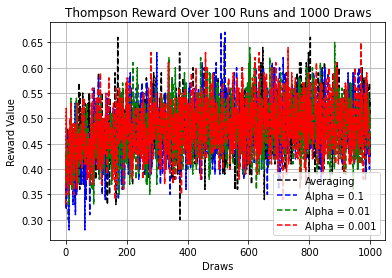

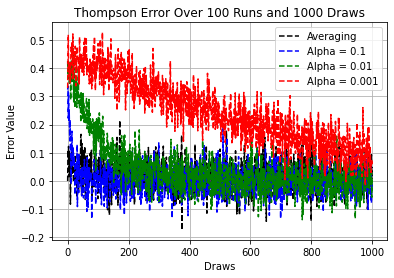

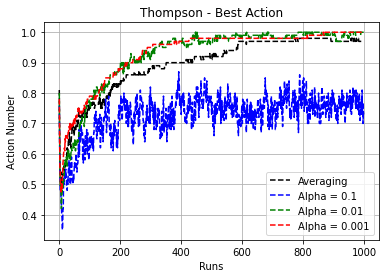

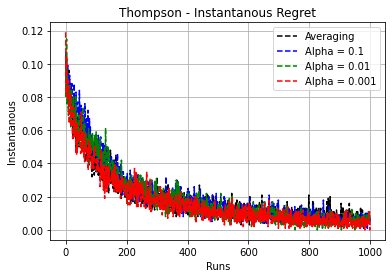

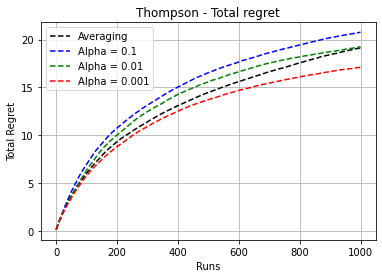

In [ ]:
# Q7
# Thompson sampling with averaging, alpha = 0.1, 0.01, 0.001
print("QUESTION 7")
true_rewards = [0.5, 0.4, 0.3]
alphas = [0.1, 0.01, 0.001]
bandits = [Bandit(alpha=alp, thompson=True) for alp in alphas]
bandits.insert(0, Bandit(increment=True, thompson=True))
draws = 1000
runs = 100
k_arms = 3
action_rewards = np.zeros((len(bandits), runs, draws))
estimate_rewards = np.zeros((len(bandits), runs, draws))
action_indices = np.zeros((len(bandits), runs, draws))
errors = np.zeros((len(bandits), runs, draws))
is_action1_best = np.zeros((len(bandits), runs, draws))          
intanstanous_regret = np.zeros((len(bandits), runs, draws))


for i, bandit in enumerate(bandits):
    for run in trange(runs):
        bandit.reset()
        number_successes = np.zeros(k_arms)
        number_failures = np.zeros(k_arms)
        for draw in range(draws):
            action_indices[i, run, draw] = bandit.action_select(successes=number_successes, failures=number_failures)
            action_rewards[i, run, draw] = bandit.sample()
            estimate_rewards[i, run, draw] = bandit.update_selector()[int(action_indices[i, run, draw])]
            errors[i, run, draw] = action_rewards[i, run, draw] - estimate_rewards[i, run, draw]
            intanstanous_regret[i, run, draw] = bandit.regret()

            if action_rewards[i, run, draw] == 1:
                number_successes[int(action_indices[i, run, draw])] += 1
            elif action_rewards[i, run, draw] == 0:
                  number_failures[int(action_indices[i, run, draw])] += 1
                
            is_action1_best[i, run, draw] = 1 if np.argmax(bandit.update_selector()) + 1 == 1 else 0

is_action1_best_frac = np.cumsum(is_action1_best, axis=1)/runs          
rewards_run_avg = action_rewards.mean(axis=1)
errors_run_avg = errors.mean(axis=1)
intanstanous_regret_run_avg = intanstanous_regret.mean(axis=1)
total_regret_run_avg = np.cumsum(intanstanous_regret_run_avg, axis=1)

# Plotting 
colors =['k--', 'b--', 'g--', 'r--', 'c--']
plt.figure()
for i in range(len(bandits)):
    plt.plot(rewards_run_avg[i, :], colors[i])
plt.xlabel("Draws")
plt.ylabel("Reward Value")
#plt.ylim((0,1))
plt.grid()
plt.legend(["Averaging", "Alpha = 0.1", "Alpha = 0.01", "Alpha = 0.001"])
plt.title("Thompson Reward Over 100 Runs and 1000 Draws")
plt.savefig('figure_7_1.png')


# Plotting
plt.figure()
for i in range(len(bandits)):
    plt.plot(errors_run_avg[i, :], colors[i])
plt.xlabel("Draws")
plt.ylabel("Error Value")
#plt.ylim((0,1))
plt.grid()
plt.legend(["Averaging", "Alpha = 0.1", "Alpha = 0.01", "Alpha = 0.001"])
plt.title("Thompson Error Over 100 Runs and 1000 Draws")
plt.savefig('figure_7_2.png')


# Plotting
colors =['k--', 'b--', 'g--', 'r--', 'c--']
plt.figure()
for i in range(len(bandits)):
    plt.plot(is_action1_best_frac[i, -1, :], colors[i])
plt.xlabel("Runs")
plt.ylabel("Action Number")
#plt.ylim((0,4))
plt.grid()
plt.legend(["Averaging", "Alpha = 0.1", "Alpha = 0.01", "Alpha = 0.001"])
plt.title("Thompson - Best Action")
plt.savefig('figure_7_3.png')


# plotting
colors =['k--', 'b--', 'g--', 'r--', 'c--']
plt.figure()
for i in range(len(bandits)):
    plt.plot(intanstanous_regret_run_avg[i, :], colors[i])
plt.xlabel("Runs")
plt.ylabel("Instantanous")
plt.grid()
plt.legend(["Averaging", "Alpha = 0.1", "Alpha = 0.01", "Alpha = 0.001"])
plt.title("Thompson - Instantanous Regret")
plt.savefig('figure_7_4.png')


# plotting
colors =['k--', 'b--', 'g--', 'r--', 'c--']
plt.figure()
for i in range(len(bandits)):
    plt.plot(total_regret_run_avg[i, :], colors[i])
plt.xlabel("Runs")
plt.ylabel("Total Regret")
plt.grid()
plt.legend(["Averaging", "Alpha = 0.1", "Alpha = 0.01", "Alpha = 0.001"])
plt.title("Thompson - Total regret")
plt.savefig('figure_7_5.png')



QUESTION 6


  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-2-ec2877e42a84>:60: RuntimeWarning: invalid value encountered in sqrt
  self.action_index = np.argmax(self.estimate_reward + self.UCB_constant*np.sqrt(np.log(self.time_step + 0.1)/(self.N_t + 0.1))) #to avoid dividing by zero
100%|██████████| 100/100 [00:04<00:00, 20.60it/s]


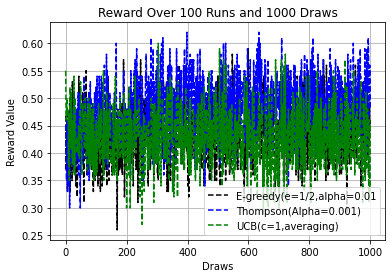

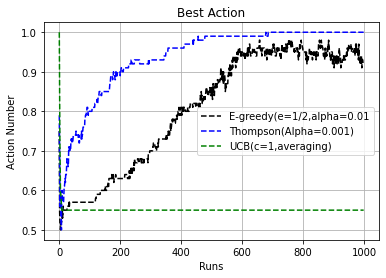

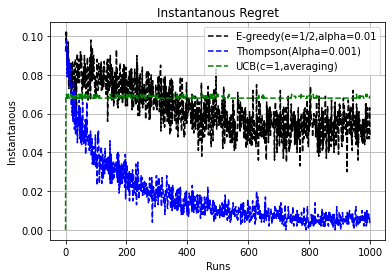

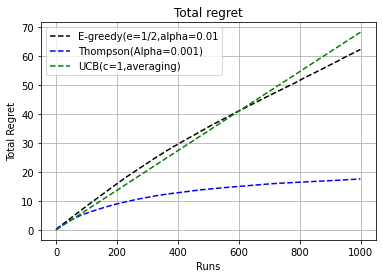

In [ ]:
#Q8 e-greedy best with epsilon = 1/2 and alpha = 0.01, thompson alpha = 0.001, ucb constant = 1 and averaging
print("QUESTION 6")
true_rewards = [0.5, 0.4, 0.3]
ucbs = [0.5, 1, np.sqrt(2), 2, 3]
bandits = [Bandit(epsilon=1/2, alpha=0.01), Bandit(thompson=True, alpha=0.001), 
            Bandit(UCB_constant=1, increment=True)]
draws = 1000
runs = 100
k_arms = 3
action_rewards = np.zeros((len(bandits), runs, draws))
estimate_rewards = np.zeros((len(bandits), runs, draws))
action_indices = np.zeros((len(bandits), runs, draws))
errors = np.zeros((len(bandits), runs, draws))
is_action1_best = np.zeros((len(bandits), runs, draws))
intanstanous_regret = np.zeros((len(bandits), runs, draws))


for i, bandit in enumerate(bandits):
    for run in trange(runs):
        bandit.reset()
        number_successes = np.zeros(k_arms)
        number_failures = np.zeros(k_arms)
        for draw in range(draws):
            action_indices[i, run, draw] = bandit.action_select(successes=number_successes, failures=number_failures)
            action_rewards[i, run, draw] = bandit.sample()
            estimate_rewards[i, run, draw] = bandit.update_selector()[int(action_indices[i, run, draw])]
            errors[i, run, draw] = action_rewards[i, run, draw] - estimate_rewards[i, run, draw]
            intanstanous_regret[i, run, draw] = bandit.regret()
            if action_rewards[i, run, draw] == 1:
                number_successes[int(action_indices[i, run, draw])] += 1
            elif action_rewards[i, run, draw] == 0:
                  number_failures[int(action_indices[i, run, draw])] += 1
                
            is_action1_best[i, run, draw] = 1 if np.argmax(bandit.update_selector()) + 1 == 1 else 0


is_action1_best_frac = np.cumsum(is_action1_best, axis=1)/runs        
rewards_run_avg = action_rewards.mean(axis=1)
errors_run_avg = errors.mean(axis=1)
intanstanous_regret_run_avg = intanstanous_regret.mean(axis=1)
total_regret_run_avg = np.cumsum(intanstanous_regret_run_avg, axis=1)

# Plotting 
colors =['k--', 'b--', 'g--', 'r--', 'c--']
plt.figure()
for i in range(len(bandits)):
    plt.plot(rewards_run_avg[i, :], colors[i])
plt.xlabel("Draws")
plt.ylabel("Reward Value")
#plt.ylim((0,1))
plt.grid()
plt.legend(["E-greedy(e=1/2,alpha=0.01", "Thompson(Alpha=0.001)", "UCB(c=1,averaging)"])
plt.title("Reward Over 100 Runs and 1000 Draws")
plt.savefig('figure_8_1.png')

# Plotting
colors =['k--', 'b--', 'g--', 'r--', 'c--']
plt.figure()
for i in range(len(bandits)):
    plt.plot(is_action1_best_frac[i, -1, :], colors[i])
plt.xlabel("Runs")
plt.ylabel("Action Number")
#plt.ylim((0,4))
plt.grid()
plt.legend(["E-greedy(e=1/2,alpha=0.01", "Thompson(Alpha=0.001)", "UCB(c=1,averaging)"])
plt.title("Best Action")
plt.savefig('figure_8_2.png')


# plotting
colors =['k--', 'b--', 'g--', 'r--', 'c--']
plt.figure()
for i in range(len(bandits)):
    plt.plot(intanstanous_regret_run_avg[i, :], colors[i])
plt.xlabel("Runs")
plt.ylabel("Instantanous")
plt.grid()
plt.legend(["E-greedy(e=1/2,alpha=0.01", "Thompson(Alpha=0.001)", "UCB(c=1,averaging)"])
plt.title("Instantanous Regret")
plt.savefig('figure_8_3.png')


# plotting
colors =['k--', 'b--', 'g--', 'r--', 'c--']
plt.figure()
for i in range(len(bandits)):
    plt.plot(total_regret_run_avg[i, :], colors[i])
plt.xlabel("Runs")
plt.ylabel("Total Regret")
plt.grid()
plt.legend(["E-greedy(e=1/2,alpha=0.01", "Thompson(Alpha=0.001)", "UCB(c=1,averaging)"])
plt.title("Total regret")
plt.savefig('figure_8_4.png')

QUESTION 9 part 1


  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-2-ec2877e42a84>:60: RuntimeWarning: invalid value encountered in sqrt
  self.action_index = np.argmax(self.estimate_reward + self.UCB_constant*np.sqrt(np.log(self.time_step + 0.1)/(self.N_t + 0.1))) #to avoid dividing by zero
100%|██████████| 100/100 [00:05<00:00, 19.97it/s]


QUESTION 9 part 2


  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-2-ec2877e42a84>:60: RuntimeWarning: invalid value encountered in sqrt
  self.action_index = np.argmax(self.estimate_reward + self.UCB_constant*np.sqrt(np.log(self.time_step + 0.1)/(self.N_t + 0.1))) #to avoid dividing by zero
100%|██████████| 100/100 [00:05<00:00, 19.48it/s]


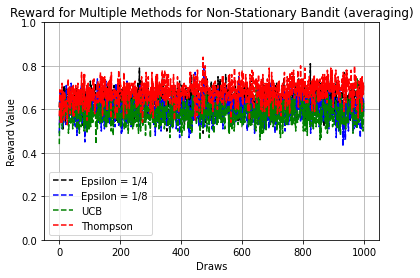

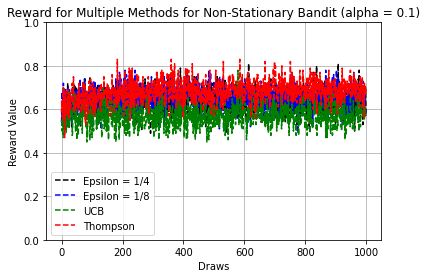

In [ ]:
# Q9 (part 1 with averaging)
# Non-stationary
print("QUESTION 9 part 1")
true_rewards = [0.5, 0.4, 0.3]
bandits = [Bandit(epsilon=1/4, increment=True), Bandit(epsilon=1/8, increment=True), 
            Bandit(UCB_constant=2, increment=True), Bandit(thompson=True, increment=True)]
draws = 1000
runs = 100
k_arms = 3
action_rewards = np.zeros((len(bandits), runs, draws))
estimate_rewards = np.zeros((len(bandits), runs, draws))
action_indices = np.zeros((len(bandits), runs, draws))
errors = np.zeros((len(bandits), runs, draws))
is_action1_best = np.zeros((len(bandits), runs, draws))          
intanstanous_regret = np.zeros((len(bandits), runs, draws))


for i, bandit in enumerate(bandits):
    for run in trange(runs):
        bandit.reset()
        number_successes = np.zeros(k_arms)
        number_failures = np.zeros(k_arms)
        for draw in range(draws):
            action_indices[i, run, draw] = bandit.action_select(successes=number_successes, failures=number_failures)
            action_rewards[i, run, draw] = bandit.sample()
            estimate_rewards[i, run, draw] = bandit.update_selector()[int(action_indices[i, run, draw])]
            errors[i, run, draw] = action_rewards[i, run, draw] - estimate_rewards[i, run, draw]
            intanstanous_regret[i, run, draw] = bandit.regret()
            if draw == 500:
                bandit.non_stationary(d=0.1)

            if action_rewards[i, run, draw] == 1:
                number_successes[int(action_indices[i, run, draw])] += 1
            elif action_rewards[i, run, draw] == 0:
                  number_failures[int(action_indices[i, run, draw])] += 1
                
            is_action1_best[i, run, draw] = 1 if np.argmax(bandit.update_selector()) + 1 == 1 else 0


is_action1_best_frac = np.cumsum(is_action1_best, axis=1)/runs        
rewards_run_avg = action_rewards.mean(axis=1)
errors_run_avg = errors.mean(axis=1)
intanstanous_regret_run_avg = intanstanous_regret.mean(axis=1)
total_regret_run_avg = np.cumsum(intanstanous_regret_run_avg, axis=1)

# Plotting 
colors =['k--', 'b--', 'g--', 'r--']
plt.figure()
for i in range(len(bandits)):
    plt.plot(rewards_run_avg[i, :], colors[i])
plt.xlabel("Draws")
plt.ylabel("Reward Value")
plt.ylim((0,1))
plt.grid()
plt.legend(["Epsilon = 1/4", "Epsilon = 1/8", "UCB", "Thompson"])
plt.title("Reward for Multiple Methods for Non-Stationary Bandit (averaging)")
plt.savefig('figure_8_1.png')


#-------------------------------------------------------------------------------------------
# Q9 (part 2 with alpha = 0.1)
# Non-stationary
print("QUESTION 9 part 2")
true_rewards = [0.5, 0.4, 0.3]
bandits = [Bandit(epsilon=1/4, alpha=0.1), Bandit(epsilon=1/8, alpha=0.1), 
            Bandit(UCB_constant=2, alpha=0.1), Bandit(thompson=True, alpha=0.1)]
draws = 1000
runs = 100
k_arms = 3
action_rewards = np.zeros((len(bandits), runs, draws))
estimate_rewards = np.zeros((len(bandits), runs, draws))
action_indices = np.zeros((len(bandits), runs, draws))
errors = np.zeros((len(bandits), runs, draws))
is_action1_best = np.zeros((len(bandits), runs, draws))          
intanstanous_regret = np.zeros((len(bandits), runs, draws))


for i, bandit in enumerate(bandits):
    for run in trange(runs):
        bandit.reset()
        number_successes = np.zeros(k_arms)
        number_failures = np.zeros(k_arms)
        for draw in range(draws):
            action_indices[i, run, draw] = bandit.action_select(successes=number_successes, failures=number_failures)
            action_rewards[i, run, draw] = bandit.sample()
            estimate_rewards[i, run, draw] = bandit.update_selector()[int(action_indices[i, run, draw])]
            errors[i, run, draw] = action_rewards[i, run, draw] - estimate_rewards[i, run, draw]
            intanstanous_regret[i, run, draw] = bandit.regret()
            if draw == 500:
                bandit.non_stationary(d=0.1)

            if action_rewards[i, run, draw] == 1:
                number_successes[int(action_indices[i, run, draw])] += 1
            elif action_rewards[i, run, draw] == 0:
                  number_failures[int(action_indices[i, run, draw])] += 1
                
            is_action1_best[i, run, draw] = 1 if np.argmax(bandit.update_selector()) + 1 == 1 else 0


is_action1_best_frac = np.cumsum(is_action1_best, axis=1)/runs           
rewards_run_avg = action_rewards.mean(axis=1)
errors_run_avg = errors.mean(axis=1)
intanstanous_regret_run_avg = intanstanous_regret.mean(axis=1)
total_regret_run_avg = np.cumsum(intanstanous_regret_run_avg, axis=1)

# Plotting 
colors =['k--', 'b--', 'g--', 'r--']
plt.figure()
for i in range(len(bandits)):
    plt.plot(rewards_run_avg[i, :], colors[i])
plt.xlabel("Draws")
plt.ylabel("Reward Value")
plt.ylim((0,1))
plt.grid()
plt.legend(["Epsilon = 1/4", "Epsilon = 1/8", "UCB", "Thompson"])
plt.title("Reward for Multiple Methods for Non-Stationary Bandit (alpha = 0.1)")
plt.savefig('figure_8_2.png')

#  plt.show()